Check clipped-SSTM and clipped-SGD on ResNet18 + ImageNet-100 task

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from graph_plot_tools import *
from utils import *

### Dataset read

In [2]:
data_path = "/path/to/kaggle/data" # there must be "/train" and "/val" subfolders with first 100 classes of imagenet

In [3]:
import torch
import scipy.stats
import tqdm

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2070 SUPER


In [4]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

input_size = 224
batch_size = 32
n_worker = 2

n_class = 100

traindir = data_path + "/train"

In [5]:
import random

seed_val = 123
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True,
    num_workers=n_worker, pin_memory=True)


train_loader_wo_crops = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.Resize((int(input_size), int(input_size))),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True,
    num_workers=n_worker, pin_memory=True)


valdir = data_path + "/val"

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize((int(input_size), int(input_size))),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker, pin_memory=True)

classes = [i for i in range(1, n_class + 1)]

### Tasks (models + optimizers)

In [6]:
import torch.nn as nn
import torch.optim as optim

from optimizers import clipped_SGD, clipped_SSTM

nets = []

history_random_seed = 891

for starting_point_random_seed in [123]:
    for _ in range(4):
        # setting the same starting point for all algorithms
        torch.manual_seed(starting_point_random_seed)

        nets.append(
            models.resnet18()
        )

        nets[-1].zero_grad()
        nets[-1].train()

torch.manual_seed(history_random_seed)


criterion = nn.CrossEntropyLoss()


opts = []
for i in range(1):
    opts += [
        optim.SGD(nets[i * 4 + 0].parameters(), lr=0.01, momentum=0.9),
        optim.Adam(nets[i * 4 + 1].parameters(), lr=1e-3),
        clipped_SSTM(nets[i * 4 + 2].parameters(), lr=0.01, L=10, clipping_type='norm', 
                     a_k_ratio_upper_bound=0.99), 
        clipped_SGD(nets[i * 4 + 3].parameters(), lr=5e-2, momentum=0.9, 
                    clipping_type="coordinate_wise", clipping_level=0.1),
    ]
    
opt_names = [
    "SGD, 0.01, 0.9, bs_mul = 1",
    "Adam, 1e-3, bs_mul = 4",
    "clipped_SSTM, 0.01, 10, norm, 1, nu=1, ratio=0.99, bs_mul = 2",
    "clipped_SGD, 5e-2, 0.9, coordinate_wise, 0.1, bs_mul = 1",
] * 1

bs_muls = [
    1, 4, 2, 1,
] * 1

lr_decays = [
    1, 1, 1, 1
#     1, 0.99995
] * 1

hist = []

for (net, optimizer, opt_name, bs_mul, lr_decay) in zip(nets, opts, opt_names, bs_muls, lr_decays):
    net.to(device)
    hist.append({
        "task_name": "Resnet-18 on ImageNet-100",
        "name": opt_name, 
        "bs_mul": bs_mul,
        "lr_decay": lr_decay,
        "train_loss": [], "train_x": [], 
        "val_loss": [], "val_x": [], 
        "train_acc_top_1": [], "train_acc_top_5": [], 
        "val_acc_top_1": [], "val_acc_top_5": [], 
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

### Norm diffs functions

In [7]:
import scipy
from scipy import stats
from tqdm.notebook import tqdm

def get_batch_grad(model):
    gr=[]
    for i in model.parameters():
        if i.requires_grad:
            gr.append(i.grad.view(-1))
    return torch.cat(gr)


def get_loss(model, criterion, batch):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    return loss


def compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad):
    fully_grad = []
    optimizer.zero_grad()

    print("Computing full gradient")
    with tqdm(total=len(dataloader_for_full_grad)) as pbar:
        for step, batch in enumerate(dataloader_for_full_grad):
            loss = get_loss(model, criterion, batch)
            loss.backward()

            if fully_grad != []:
                fully_grad = fully_grad + get_batch_grad(model) * \
                    dataloader_for_full_grad.batch_size
            else:
                fully_grad = get_batch_grad(model) * dataloader_for_full_grad.batch_size
            optimizer.zero_grad()

            pbar.update(1)

    return fully_grad / (step * dataloader_for_full_grad.batch_size)


def compute_norm_diffs(model, optimizer, criterion, dataloader_for_full_grad, dataloader, full_grad=None, repeats=1):
    if full_grad is None:
        full_grad = compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad)
    mini_norms = []
    optimizer.zero_grad()

    print("Computing norm diffs")
    with tqdm(total=repeats * len(dataloader)) as pbar:
        for _ in range(repeats):
            for step, batch in enumerate(dataloader):
                loss = get_loss(model, criterion, batch)
                loss.backward()

                mini_norms.append((get_batch_grad(model) - full_grad).norm().item())
                optimizer.zero_grad()

                pbar.update(1)

    return np.array(mini_norms)

In [8]:
from copy import deepcopy
import numpy as np

def get_loss(model, criterion, batch):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    return loss

def recursive_to(param, device):
    # Not sure if there are any global tensors in the state dict
    if isinstance(param, torch.Tensor):
        param.data = param.data.to(device)
        if param._grad is not None:
            param._grad.data = param._grad.data.to(device)
    elif isinstance(param, dict):
        for subparam in param.values():
            recursive_to(subparam, device)
    elif isinstance(param, list):
        for subparam in param:
            recursive_to(subparam, device)

def optimizer_to(optim, device):
    for param_group in optim.param_groups:
        for param in param_group.values():
            # Not sure there are any global tensors in the state dict
            recursive_to(param, device)

### Training

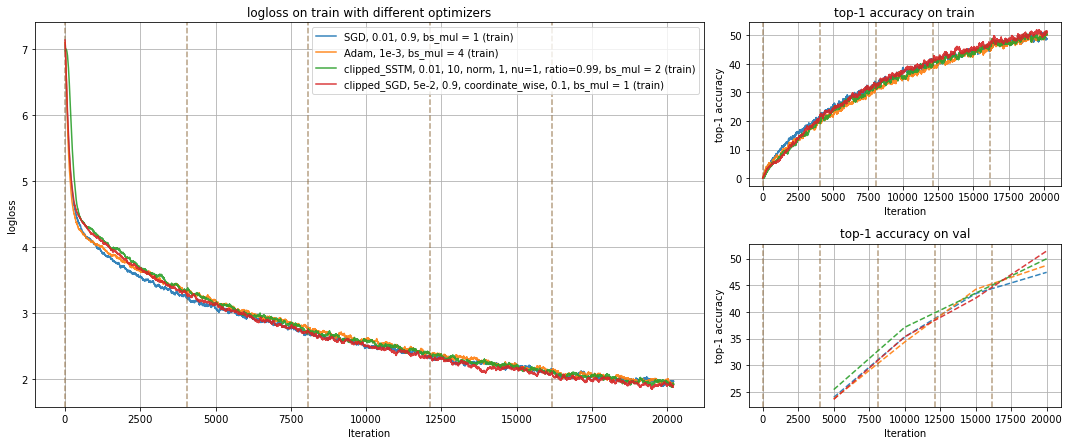

Finished Training


In [10]:
from IPython import display

batch_mul_step_count = 5000

norm_diffs_step_count = 5000
val_step_count = 5000
calc_norm_diffs = False


for epoch in range(5):  # loop over the dataset multiple times
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
#         net.to(device)
#         optimizer_to(optimizer, device)

        total_steps = net_hist["total_steps"]
        # effective batch size will be batch_size * bs_mul
        bs_mul = net_hist["bs_mul"]
        # learning rate decay rate
        lr_decay = net_hist["lr_decay"]
            
        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]
            
        net_hist["epochs_x"].append(total_steps)

        for i, data in enumerate(train_loader, 0):

            # compute norm diffs distribution on train dataset
            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or 
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer, None, 
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            ######################################################################
            if lr_decay < 1:
                for g in optimizer.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            ######################################################################
            
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)
            
            loss = criterion(outputs, labels) / bs_mul
            loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer.step()
                optimizer.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1 
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(outputs.data, labels.data, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            # evaluate on validation dataset
            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                
                with torch.no_grad():
                    for step, val_data in enumerate(val_loader):

                        inputs, labels = val_data[0].to(device), val_data[1].to(device)

                        outputs = net(inputs)

                        loss = criterion(outputs, labels)

                        val_losses.append(loss.detach().cpu().item())

                        top_1, top_5 = accuracy(outputs.data, labels.data, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())

                net_hist["val_loss"].append(np.mean(val_losses))
                net_hist["val_x"].append(total_steps)

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))

                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)
                
                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, eps=0.01, 
                    make_val=False, alpha=0.9)
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01, 
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01, 
                    make_train=False, make_val=True, top_k=1, alpha=0.9)
                
                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
#         net.to("cpu")
#         optimizer_to(optimizer, "cpu")

print('Finished Training')

### Save models / train data

In [11]:
from datetime import datetime

now = datetime.now()
now = str(now)

In [12]:
save_net_weights = False


if save_net_weights:
    for i in range(len(nets)):
        if "/" in hist[i]["name"]:
            hist[i]["name"] = ":".join(hist[i]["name"].split("/"))
        PATH = './models/resnet_18_{}.pth'.format(
            "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":") + hist[i]["name"].split())
        )
        torch.save(nets[0].state_dict(), PATH)

In [13]:
from copy import deepcopy

hist3 = deepcopy(hist)

In [14]:
for h in hist3:
    for key in h:
        if isinstance(h[key], list) and  len(h[key])> 0 :
            if isinstance(h[key][0], torch.Tensor):
                for i in range(len(h[key])):
                    h[key][i] = h[key][i].numpy()
            if isinstance(h[key][0], np.ndarray):
                for i in range(len(h[key])):
                    if len(h[key][i]) == 1:
                        h[key][i] = np.asscalar(h[key][i])
                    else:
                        h[key][i] = [str(x) for x in h[key][i]]
            for i in range(len(h[key])):
                if not isinstance(h[key][i], list):
                    h[key][i] = str(h[key][i])

In [15]:
import json
with open('./models/resnet_18_{}_train_hist.json'.format("_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":")))
          , 'w') as fout:
    json.dump(hist3 , fout)

### Averaged plots

In [10]:
import json
hists_names_list = [
    "resnet_18_2021-06-04_10_49_43_train_hist",
#     "resnet_18_2021-06-04_03_39_08_train_hist", # 0.001 2
#     "resnet_18_2021-06-03_21_56_31_train_hist", # 128 wo mod
#     "resnet_18_2021-06-03_21_56_24_train_hist", # 2 w mod
#     "resnet_18_2021-05-26_19_39_06_train_hist", # adam
]

hist = hist_from_json(load_hist_jsons(hists_names_list))

In [11]:
grouped_hist = group_uniques_full(
    hist, 
    ["train_loss", "val_loss", "train_acc_top_1", "val_acc_top_1"], 
#     ["train_loss", "train_acc_top_1"], 
    verbose=True,
    group_norm_diffs=True
)

# grouped_hist = grouped_hist[0:20]

def key(h, alpha=1):
    return smooth(h["val_loss"], alpha)[-1]

grouped_hist = sorted(grouped_hist, key=key)

Repeats_1 = 1.0, Name = SGD, 0.01, 0.9, bs_mul = 1
Repeats_1 = 1.0, Name = Adam, 1e-3, bs_mul = 4
Repeats_1 = 1.0, Name = clipped_SSTM, 0.01, 10, norm, 1, nu=1, ratio=0.99, bs_mul = 2
Repeats_1 = 1.0, Name = clipped_SGD, 5e-2, 0.9, coordinate_wise, 0.1, bs_mul = 1


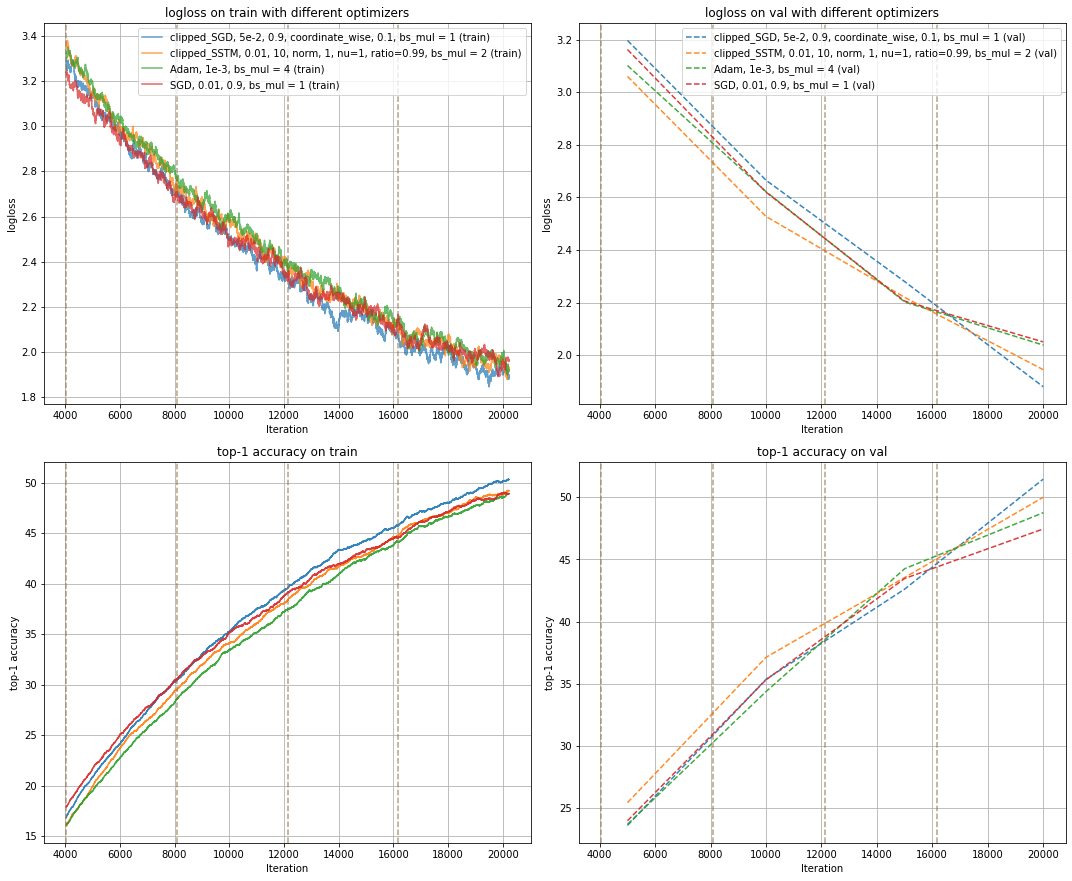

In [16]:
fig = plt.figure(figsize=(15,18))
gs = GridSpec(3,2, figure=fig)


display.clear_output(wait=True)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

ax1 = make_loss_plot(ax1, grouped_hist, eps=0.01, make_val=False, alpha=0.7, starting_epoch=1)
ax2 = make_loss_plot(ax2, grouped_hist, eps=0.01, make_train=False, alpha=0.9, starting_epoch=1)
ax3 = make_accuracy_plot(ax3, grouped_hist, eps=0.001, make_train=True,
                         make_val=False, top_k=1, alpha=0.9, starting_epoch=1)
ax4 = make_accuracy_plot(ax4, grouped_hist, eps=0.01, make_train=False,
                         make_val=True, top_k=1, alpha=0.9, starting_epoch=1)

# grouped_hist_for_distrs = [grouped_hist[0], grouped_hist[1], grouped_hist[3]]

# draw_norm_hists_for_different_models(fig, gs[2:,:], grouped_hist_for_distrs, bins_n=100, draw_normal=True, number=-1)

gs.tight_layout(fig)
plt.draw()
plt.show()

### norm diffs distribution batch size  dependance

In [23]:
import random
seed_val = 43
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

traindir = data_path + "/train"

bss = [1, 2, 4, 8, 16, 32]

train_loaders = [
    torch.utils.data.DataLoader(
        datasets.ImageFolder(traindir, transforms.Compose([
            transforms.Resize((int(input_size), int(input_size))),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=bs, shuffle=True,
        num_workers=n_worker, pin_memory=True
    ) for bs in bss
]

In [24]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

net = models.resnet18()
net.load_state_dict(torch.load("./models/2021-04-27_12_32_29_clipped_SSTM,_0.1,_100,_norm.pth"))

opt = clipped_SSTM(net.parameters(), lr=0.1, L=100, clipping_type='norm')

net.to(device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
from tqdm.notebook import tqdm

norm_diffs_with_different_train_loaders = {}

for (bs, train_loader_with_spec_bs) in tqdm(zip(bss, train_loaders)):
    norm_diffs_with_different_train_loaders[bs] = compute_norm_diffs(
            net, opt, criterion, 
            train_loader_wo_resizes, train_loader_with_spec_bs
    )

0it [00:00, ?it/s]

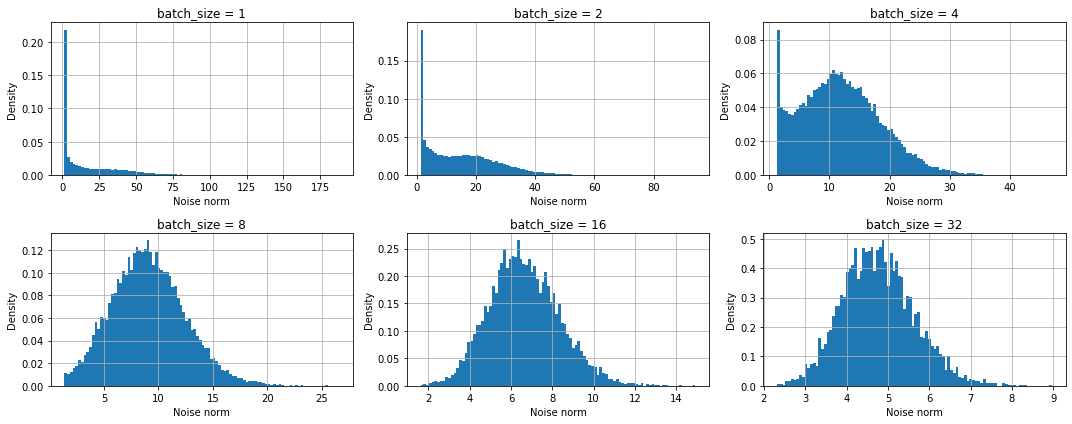

In [30]:
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(2,3, figure=fig)

bins_n = 100
draw_normal = False

axs = []

for i in range(2):
    for j in range(3):
        axs.append(fig.add_subplot(gs[i,j]))

for (ax, bs) in zip(axs, bss):
    norm_diffs = norm_diffs_with_different_train_loaders[bs]

    if len(norm_diffs) > 0:
        ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)

    ax.set_title("batch_size = {}".format(bs))
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

gs.tight_layout(fig)
plt.draw()

from datetime import datetime

now = datetime.now()
now = str(now)

PATH = './models/{}_result_graph_wo_normal.pdf'.format(
        "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":"))
)

plt.savefig(PATH, format='pdf')

In [35]:
from copy import deepcopy

h = deepcopy(norm_diffs_with_different_train_loaders)

for key in h:
    if isinstance(h[key], np.ndarray):
        h[key] = [str(x) for x in h[key]]
                    
import json
with open('./models/{}_batch_size_hist.json'.format("_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":")))
          , 'w') as fout:
    json.dump(h , fout)
    

### First iteration norm diffs distribution

In [40]:
import random
seed_val = 43
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


import torch.nn as nn
import torch.optim as optim

types = 3
rep = 5

nets = [models.resnet18() for i in range(types * rep)]

criterion = nn.CrossEntropyLoss()

opts = [None for i in range(types * rep)]
bss = [None for i in range(types * rep)]

for i in range(0, rep):
    opts[i] = clipped_SSTM(nets[i].parameters(), lr=0.1, L=100, clipping_type='norm')
    bss[i] = "SSTM"
    opts[i + rep] = optim.Adam(nets[i + rep].parameters(), lr=0.001)
    bss[i + rep] = "Adam"
    opts[i + 2 * rep] = optim.SGD(nets[i + 2 * rep].parameters(), lr=0.1, momentum=0.9)
    bss[i + 2 * rep] = "SGD"
    
for i in range(0, types * rep):
    nets[i].to(device)
    nets[i].eval()

In [41]:
traindir = data_path + "/train"

train_loader_wo_resizes = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.Resize((int(input_size), int(input_size))),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True,
    num_workers=n_worker, pin_memory=True)

train_loader_with_small_batch = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.Resize((int(input_size), int(input_size))),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=32, shuffle=True,
    num_workers=n_worker, pin_memory=True)

In [42]:
from tqdm.notebook import tqdm

norm_diffs_with_different_starts = []

for (net, opt) in tqdm(zip(nets, opts), total=len(opts)):
    norm_diffs_with_different_starts.append(
        compute_norm_diffs(
            net, opt, criterion, 
            train_loader_wo_resizes, train_loader_with_small_batch
        )
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
from datetime import datetime

now = datetime.now()
now = str(now)

In [44]:
from copy import deepcopy

h = deepcopy(norm_diffs_with_different_starts)

for i in range(len(h)):
    h[i] = [str(x) for x in h[i]]
                    
import json
with open('./models/{}_start_distr_hist.json'.format("_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":")))
          , 'w') as fout:
    json.dump(h , fout)

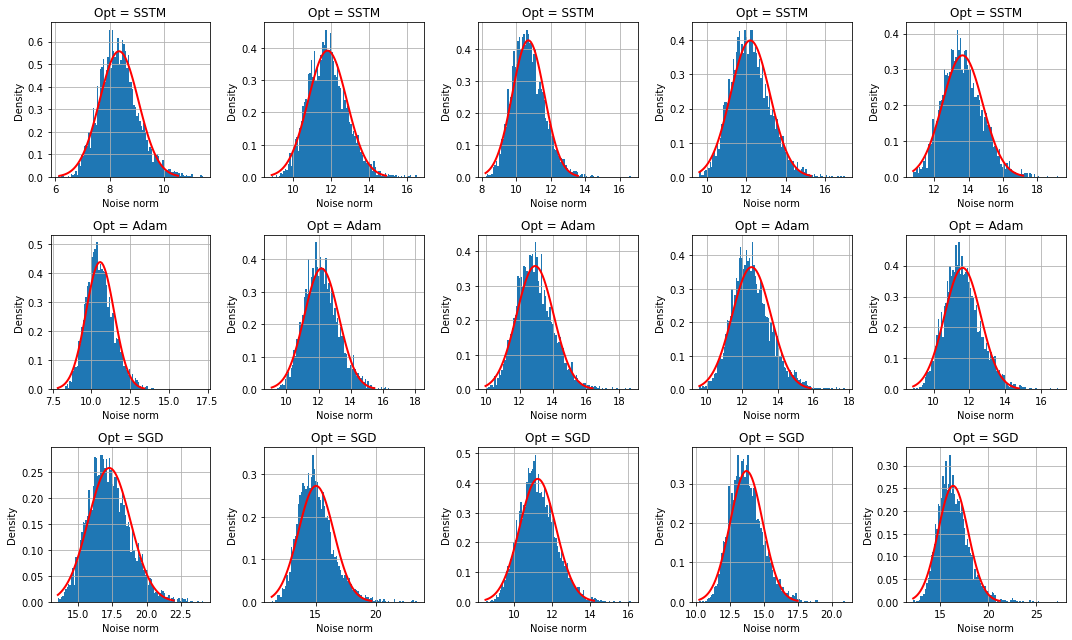

In [69]:
fig = plt.figure(figsize=(rep * 3, types * 3))
gs = GridSpec(types,rep, figure=fig)

bins_n = 100
draw_normal = True

axs = []

for i in range(types):
    for j in range(rep):
        axs.append(fig.add_subplot(gs[i,j]))

for i, (ax, bs) in enumerate(zip(axs, bss)):
    norm_diffs = norm_diffs_with_different_starts[i]

    if len(norm_diffs) > 0:
        ax = draw_norm_hist(ax, norm_diffs, bins_n=bins_n, draw_normal=draw_normal)

    ax.set_title("Opt = {}".format(bs))
    ax.set_ylabel("Density")
    ax.set_xlabel("Noise norm")
    ax.grid(True)

gs.tight_layout(fig)
plt.draw()

from datetime import datetime

now = datetime.now()
now = str(now)

PATH = './models/{}_result_start_distr_graph.pdf'.format(
        "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":"))
)

plt.savefig(PATH, format='pdf')

In [70]:
h = deepcopy(norm_diffs_with_different_starts)
for h_i in h:
    h_i[:] = (h_i - h_i.mean()) / h_i.std()
h = np.concatenate(h)

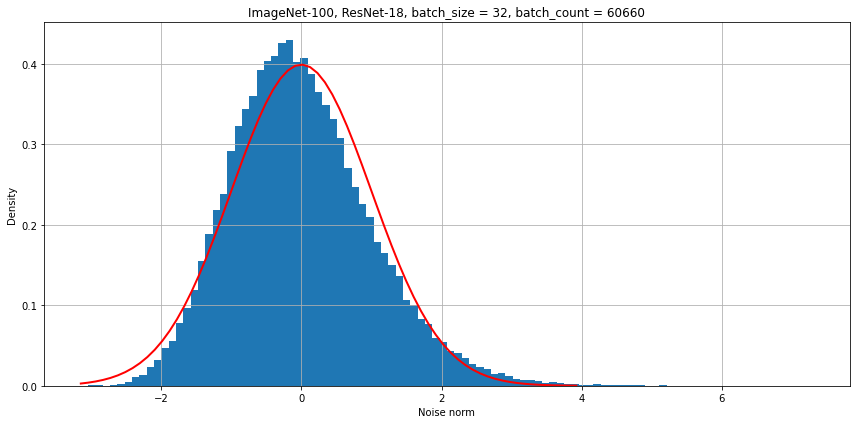

In [76]:
fig = plt.figure(figsize=(1 * 12, 1 * 6))
gs = GridSpec(1,1, figure=fig)

bins_n = 100
draw_normal = True

axs = []

ax = fig.add_subplot(gs[0,0])

ax = draw_norm_hist(ax, h, bins_n=bins_n, draw_normal=draw_normal)

ax.set_title("ImageNet-100, ResNet-18, batch_size = {}, batch_count = {}".format(32, h.shape[0]))
ax.set_ylabel("Density")
ax.set_xlabel("Noise norm")
ax.grid(True)

gs.tight_layout(fig)
plt.draw()


PATH = './models/{}_result_start_distr_graph_combined.pdf'.format(
        "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":"))
)

plt.savefig(PATH, format='pdf')